**Restricted Boltzmann Machine (RBM)**

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.astype(np.float32), mnist.target.astype(np.int64)

# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.01, epochs=10, batch_size=64):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size

        # Initialize weights and biases
        self.weights = tf.Variable(tf.random.normal([self.visible_units, self.hidden_units], stddev=0.01))
        self.hidden_bias = tf.Variable(tf.zeros([self.hidden_units]))
        self.visible_bias = tf.Variable(tf.zeros([self.visible_units]))

    def sigmoid(self, x):
        return tf.nn.sigmoid(x)

    def sample(self, probabilities):
        return tf.nn.relu(tf.sign(probabilities - tf.random.uniform(tf.shape(probabilities))))

    def forward(self, v):
        h_prob = self.sigmoid(tf.matmul(v, self.weights) + self.hidden_bias)
        h_sample = self.sample(h_prob)
        return h_prob, h_sample

    def backward(self, h):
        v_prob = self.sigmoid(tf.matmul(h, tf.transpose(self.weights)) + self.visible_bias)
        return v_prob

    def train(self, data):
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(self.batch_size)

        optimizer = tf.optimizers.Adam(self.learning_rate)

        for epoch in range(self.epochs):
            total_loss = 0
            for batch in dataset:
                with tf.GradientTape() as tape:
                    # Positive phase
                    h_prob, h_sample = self.forward(batch)
                    pos_associations = tf.matmul(tf.transpose(batch), h_prob)

                    # Negative phase
                    v_reconstructed = self.backward(h_sample)
                    h_reconstructed, _ = self.forward(v_reconstructed)
                    neg_associations = tf.matmul(tf.transpose(v_reconstructed), h_reconstructed)

                    # Compute gradients
                    weight_gradient = (pos_associations - neg_associations) / self.batch_size
                    visible_bias_gradient = tf.reduce_mean(batch - v_reconstructed, axis=0)
                    hidden_bias_gradient = tf.reduce_mean(h_prob - h_reconstructed, axis=0)

                    loss = tf.reduce_mean(tf.square(batch - v_reconstructed))
                    total_loss += loss.numpy()

                # Update weights and biases
                gradients = [weight_gradient, hidden_bias_gradient, visible_bias_gradient]
                optimizer.apply_gradients(zip(gradients, [self.weights, self.hidden_bias, self.visible_bias]))

            print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data):.4f}")

    def transform(self, data):
        h_prob, _ = self.forward(data)
        return h_prob.numpy()

# Initialize and train the RBM
rbm = RBM(visible_units=784, hidden_units=128, learning_rate=0.01, epochs=10, batch_size=64)
rbm.train(X_train)

# Extract features from training and test data
X_train_features = rbm.transform(X_train)
X_test_features = rbm.transform(X_test)

Epoch 1, Loss: 0.0133
Epoch 2, Loss: 0.0133
Epoch 3, Loss: 0.0133
Epoch 4, Loss: 0.0133
Epoch 5, Loss: 0.0133
Epoch 6, Loss: 0.0133
Epoch 7, Loss: 0.0133
Epoch 8, Loss: 0.0133
Epoch 9, Loss: 0.0133
Epoch 10, Loss: 0.0133


In [2]:
# Train a Logistic Regression model on extracted features
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_features, y_train)

# Make predictions
y_pred = clf.predict(X_test_features)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.4f}")


Classification Accuracy: 0.1143


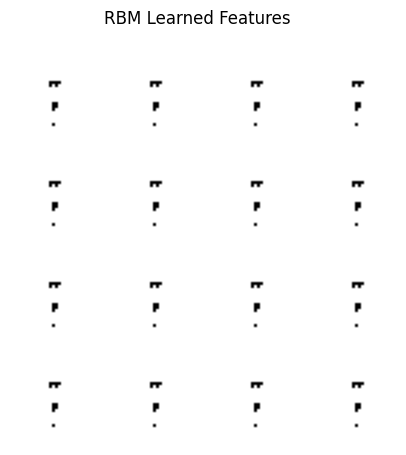

In [3]:
# Visualize first 16 feature detectors (weights)
fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(rbm.weights.numpy()[:, i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.suptitle("RBM Learned Features")
plt.show()


**Implementation of Stacked RBM**

In [5]:
import numpy as np

class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.1, epochs=500):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.epochs = epochs

        # Initialize weights and biases
        self.weights = np.random.normal(0, 0.01, (self.visible_units, self.hidden_units))
        self.hidden_bias = np.zeros((1, self.hidden_units))
        self.visible_bias = np.zeros((1, self.visible_units))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, probabilities):
        return (np.random.rand(*probabilities.shape) < probabilities).astype(np.float32)

    def train(self, data):
        for epoch in range(self.epochs):
            # Positive phase
            pos_hidden_probs = self.sigmoid(np.dot(data, self.weights) + self.hidden_bias)
            pos_hidden_states = self.sample(pos_hidden_probs)
            pos_associations = np.dot(data.T, pos_hidden_probs)

            # Negative phase
            neg_visible_probs = self.sigmoid(np.dot(pos_hidden_states, self.weights.T) + self.visible_bias)
            neg_visible_states = self.sample(neg_visible_probs)
            neg_hidden_probs = self.sigmoid(np.dot(neg_visible_states, self.weights) + self.hidden_bias)
            neg_associations = np.dot(neg_visible_states.T, neg_hidden_probs)

            # Update weights and biases
            self.weights += self.learning_rate * ((pos_associations - neg_associations) / data.shape[0])
            self.visible_bias += self.learning_rate * np.mean(data - neg_visible_states, axis=0, keepdims=True)
            self.hidden_bias += self.learning_rate * np.mean(pos_hidden_probs - neg_hidden_probs, axis=0, keepdims=True)

            if epoch % 100 == 0:
                error = np.mean((data - neg_visible_states) ** 2)
                print(f"Epoch {epoch}: Reconstruction Error = {error:.4f}")

    def transform(self, data):
        return self.sigmoid(np.dot(data, self.weights) + self.hidden_bias)


class StackedRBM:
    def __init__(self, layer_sizes, learning_rate=0.1, epochs=500):
        self.layer_sizes = layer_sizes
        self.rbms = []
        self.learning_rate = learning_rate
        self.epochs = epochs

        # Initialize each RBM in the stack
        for i in range(len(layer_sizes) - 1):
            self.rbms.append(RBM(layer_sizes[i], layer_sizes[i + 1], learning_rate, epochs))

    def pretrain(self, data):
        layer_input = data
        for i, rbm in enumerate(self.rbms):
            print(f"\nTraining RBM Layer {i + 1}: {rbm.visible_units} -> {rbm.hidden_units}")
            rbm.train(layer_input)
            layer_input = rbm.transform(layer_input)  # Pass transformed data to the next layer

    def transform(self, data):
        for rbm in self.rbms:
            data = rbm.transform(data)
        return data


# Example Usage
if __name__ == "__main__":
    # Generate dummy data: 10 samples, 8 features
    data = np.random.randint(0, 2, (10, 8)).astype(np.float32)

    # Define stacked RBM architecture: 8 -> 6 -> 4 hidden units
    srmb = StackedRBM(layer_sizes=[8, 6, 4], learning_rate=0.1, epochs=500)

    # Pretrain the stacked RBM
    srmb.pretrain(data)

    print("\nFinal Transformed Data:")
    print(srmb.transform(data))



Training RBM Layer 1: 8 -> 6
Epoch 0: Reconstruction Error = 0.5125
Epoch 100: Reconstruction Error = 0.5375
Epoch 200: Reconstruction Error = 0.6000
Epoch 300: Reconstruction Error = 0.4625
Epoch 400: Reconstruction Error = 0.4500

Training RBM Layer 2: 6 -> 4
Epoch 0: Reconstruction Error = 0.2725
Epoch 100: Reconstruction Error = 0.2675
Epoch 200: Reconstruction Error = 0.2782
Epoch 300: Reconstruction Error = 0.3110
Epoch 400: Reconstruction Error = 0.2951

Final Transformed Data:
[[0.49820654 0.49848738 0.49855734 0.49874819]
 [0.51535009 0.51631715 0.51600802 0.51676375]
 [0.49411806 0.49423012 0.49442964 0.49448911]
 [0.50426403 0.50480535 0.50478594 0.50519793]
 [0.50985984 0.51061733 0.51048567 0.51107679]
 [0.50132473 0.50172869 0.5017783  0.5020732 ]
 [0.51914091 0.52026332 0.51988972 0.52077927]
 [0.51005128 0.51080861 0.51063101 0.51121464]
 [0.51668747 0.51770733 0.5173928  0.51819912]
 [0.52013247 0.5213002  0.52088905 0.52180933]]
